In [1]:
import pandas as pd
import wrangle as w
import explore as e
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from functools import reduce

import matplotlib.pyplot as plt

# importing necessary libraries
import pandas as pd
import numpy as np


from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

## Recreate model data from model.ipynb notebook

In [2]:
# acquire dataframe
df = w.get_perpetrator_df()

# create production dataframe based on the target variables
production_df = df[df['gname'].str.contains('Unknown')==True]

# create target variable dataframe
df1 = df[df['gname'].str.contains('Unknown')==False]

# drop columns from the dataframe that arent relevant in the predictor
model_df = df1.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])


production_df2 = production_df.drop(columns=['event_id',
             'region',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])


production_df = production_df.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])

# change year to object type
model_df.year = model_df.year.astype('str')
production_df.year = production_df.year.astype('str')

data = model_df


### Check differences in DFs

#### Provstate from prod_df to data

In [3]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff = y.difference(x)
prov_diff = list(prov_diff)
len(prov_diff)

87

#### Data to prod_df

In [4]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff2 = x.difference(y)
prov_diff2 = list(prov_diff2)
len(prov_diff2)

19

#### City from prod_df to data

In [5]:
y = set(production_df['city'])
x = set(data['city'])

city_diff = y.difference(x)
city_diff = list(city_diff)
len(city_diff)

3165

#### city from data to prod

In [6]:
y = set(production_df['city'])
x = set(data['city'])

city_diff2 = x.difference(y)
city_diff2 = list(city_diff2)
len(city_diff2)

2125

---

In [7]:
for i in city_diff:
    production_df = production_df[production_df.city!=i]

production_df.shape

(22420, 10)

In [8]:
for x in prov_diff:
    production_df = production_df[production_df.provstate!=x]

production_df.shape

(22307, 10)

In [9]:
for i in city_diff2:
    data = data[data.city!=i]

data.shape

(10299, 10)

In [10]:
for x in prov_diff2:
    data = data[data.provstate!=x]
    
data.shape

(10289, 10)

---

### Sanity

In [11]:
y = set(production_df['city'])
x = set(data['city'])

city_diff = y.difference(x)
city_diff = list(city_diff)
len(city_diff)

2

In [12]:
y = set(production_df['city'])
x = set(data['city'])

city_diff2 = x.difference(y)
city_diff2 = list(city_diff2)
len(city_diff2)

1

In [13]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff = y.difference(x)
prov_diff = list(prov_diff)
len(prov_diff)

10

In [14]:
y = set(production_df['provstate'])
x = set(data['provstate'])

prov_diff2 = x.difference(y)
prov_diff2 = list(prov_diff2)
len(prov_diff2)

3

---

- We compare prod2 to the complete dataframe, to match the same rows that it did in the previous production dataframe

## City for pdf2

In [15]:
y = set(production_df2['city'])
x = set(production_df['city'])

city_diff3 = y.difference(x)
city_diff3 = list(city_diff3)
len(city_diff3)

3166

In [16]:
production_df2.shape

(27630, 14)

In [17]:
for i in city_diff3:
    production_df2 = production_df2[production_df2.city!=i]

production_df2.shape

(22393, 14)

## Provstate for pdf2

In [18]:
y = set(production_df2['provstate'])
x = set(production_df['provstate'])

prov_diff3 = y.difference(x)
prov_diff3 = list(prov_diff3)
len(prov_diff3)

35

In [19]:
production_df2.shape

(22393, 14)

In [20]:
for i in prov_diff3:
    production_df2 = production_df2[production_df2.provstate!=i]

production_df2.shape

(22307, 14)

### Scaling

In [21]:
# create a dataframe for the gname target variable
gnames = pd.DataFrame(data.gname)

# create nkill df
nkills = pd.DataFrame(data.nkill)

# scale nkill
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(nkills)
nkills = pd.DataFrame(scaler.transform(nkills))
nkills = nkills.rename(columns={0:'nkill'})

In [22]:
data.shape[0], gnames.shape[0], nkills.shape[0]

(10289, 10289, 10289)

### Dummy df

In [23]:
# encode variables
dummy_df = pd.get_dummies(data[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])

In [24]:
dummy_df = dummy_df.reset_index(drop=True)
dummy_df.index

RangeIndex(start=0, stop=10289, step=1)

In [25]:
gnames = gnames.reset_index(drop=True)
gnames.index

RangeIndex(start=0, stop=10289, step=1)

In [26]:
# add target to dataframe
dummy_df = pd.concat([dummy_df, gnames, nkills], axis=1)

In [27]:
dummy_df.shape

(10289, 1283)

---

### Gotta Create Lists Now... (or not)

In [28]:
# production_df['year'].nunique(), data['year'].nunique()

# production_df['city'].nunique(), data['city'].nunique()

# production_df['targtype'].nunique(), data['targtype'].nunique()

# prod = production_df['country'].unique()
# prod = prod.tolist()

# data_list =data.country.unique()
# data_list = data_list.tolist()

# data_list2 = data.provstate.unique()
# data_list2 =data_list2.tolist()

# prod2 = production_df['provstate'].unique()
# prod2 = prod2.tolist()

# prod3 = production_df['city'].unique()
# prod3 = prod3.tolist()

# data_list3 =data.city.unique()
# data_list3 = data_list3.tolist()

# # match lists function: 
# def non_match_elements(list_a, list_b):
#     non_match = []
#     for i in list_a:
#         if i not in list_b:
#             non_match.append(i)
#     return non_match

# non_match = non_match_elements(prod, data_list)
# print('Non matched countries: ', non_match)

# non_match2 = non_match_elements(prod2, data_list2)
# print('Non matched provstates: ', non_match2)

# non_match3 = non_match_elements(prod3, data_list3)
# print('Non matched cities: ', non_match3)

# len(non_match3)


# non_match3 = non_match3[:775]

# non_match

# for match in non_match:
#     production_df = production_df[production_df.country!= match]

# production_df.shape, data.shape

# non_match2

# for match2 in non_match2:
#     production_df = production_df[production_df.provstate!= match2]
    

# production_df.shape, data.shape

# for match3 in non_match3:
#     production_df = production_df[production_df.city!= match3]

# production_df.shape, data.shape

### Production Data Block

In [29]:
# size difference between prod df and og model df

In [30]:
production_df.shape

(22307, 10)

In [31]:
# create a dataframe for the gname target variable
gnames2 = pd.DataFrame(production_df.gname)

# create nkill df
nkills2 = pd.DataFrame(production_df.nkill)

scaler2 = MinMaxScaler()

scaler2.fit(nkills2)
nkills2 = nkills2.rename(columns={0:'nkill'})

In [32]:
# encode variables
dummy_df2 = pd.get_dummies(production_df[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])

In [33]:
gnames2 = gnames2.reset_index(drop=True)
gnames2.index

RangeIndex(start=0, stop=22307, step=1)

In [34]:
dummy_df2 = dummy_df2.reset_index(drop=True)
dummy_df2.index

RangeIndex(start=0, stop=22307, step=1)

In [35]:
nkills2 = nkills2.reset_index(drop=True)
nkills2.index

RangeIndex(start=0, stop=22307, step=1)

In [36]:
gnames2.shape, nkills2.shape, dummy_df2.shape

((22307, 1), (22307, 1), (22307, 1291))

In [37]:
# add target to dataframe
dummy_df2 = pd.concat([dummy_df2, gnames2, nkills2], axis=1)

#### Prod DF Size

In [38]:
#X_train2= train2.drop(columns=['gname'])
#y_train2 = train2.gname

#X_validate2 = validate2.drop(columns=['gname'])
#y_validate2 = validate2.gname

X_test2 = dummy_df2.drop(columns=['gname'])
y_test2 = dummy_df2.gname

In [39]:
X_test2.shape, y_test2.shape

((22307, 1292), (22307,))

#### OG DF Size

In [40]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.27, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.35, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [41]:
# split into train, validate, test
train, validate, test = train_validate_test_split(dummy_df, target='gname', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train= train.drop(columns=['gname'])
y_train = train.gname

X_validate = validate.drop(columns=['gname'])
y_validate = validate.gname

X_test = test.drop(columns=['gname'])
y_test = test.gname

In [42]:
X_train.shape, X_validate.shape, X_test.shape

((4881, 1282), (2629, 1282), (2779, 1282))

---

### Create Model

In [43]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=5, random_state=123)

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

# make prediction on train obeservations

y_pred = clf.predict(X_train)

# y_pred_proba = clf.predict_proba(X_train2)

# Eval model
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.94


In [44]:
metrics = []
for i in range(1, 15):
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    tree = tree.fit(X_train, y_train)
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
dt_df = pd.DataFrame(metrics)
dt_df["difference"] = dt_df.train_accuracy - dt_df.validate_accuracy
dt_df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.615448,0.612400,0.003048
1,2,0.767671,0.763408,0.004262
2,3,0.838967,0.834157,0.004810
3,4,0.899201,0.895017,0.004184
4,5,0.940586,0.935337,0.005249
5,6,0.960459,0.958159,0.002300
6,7,0.967015,0.962343,0.004672
7,8,0.968859,0.964625,0.004234
8,9,0.973161,0.965006,0.008156
9,10,0.976439,0.968049,0.008391


In [46]:
tree = DecisionTreeClassifier(max_depth=5, random_state=123)

tree = tree.fit(X_train, y_train)

tree.score(X_test, y_test)

0.9384670744872257

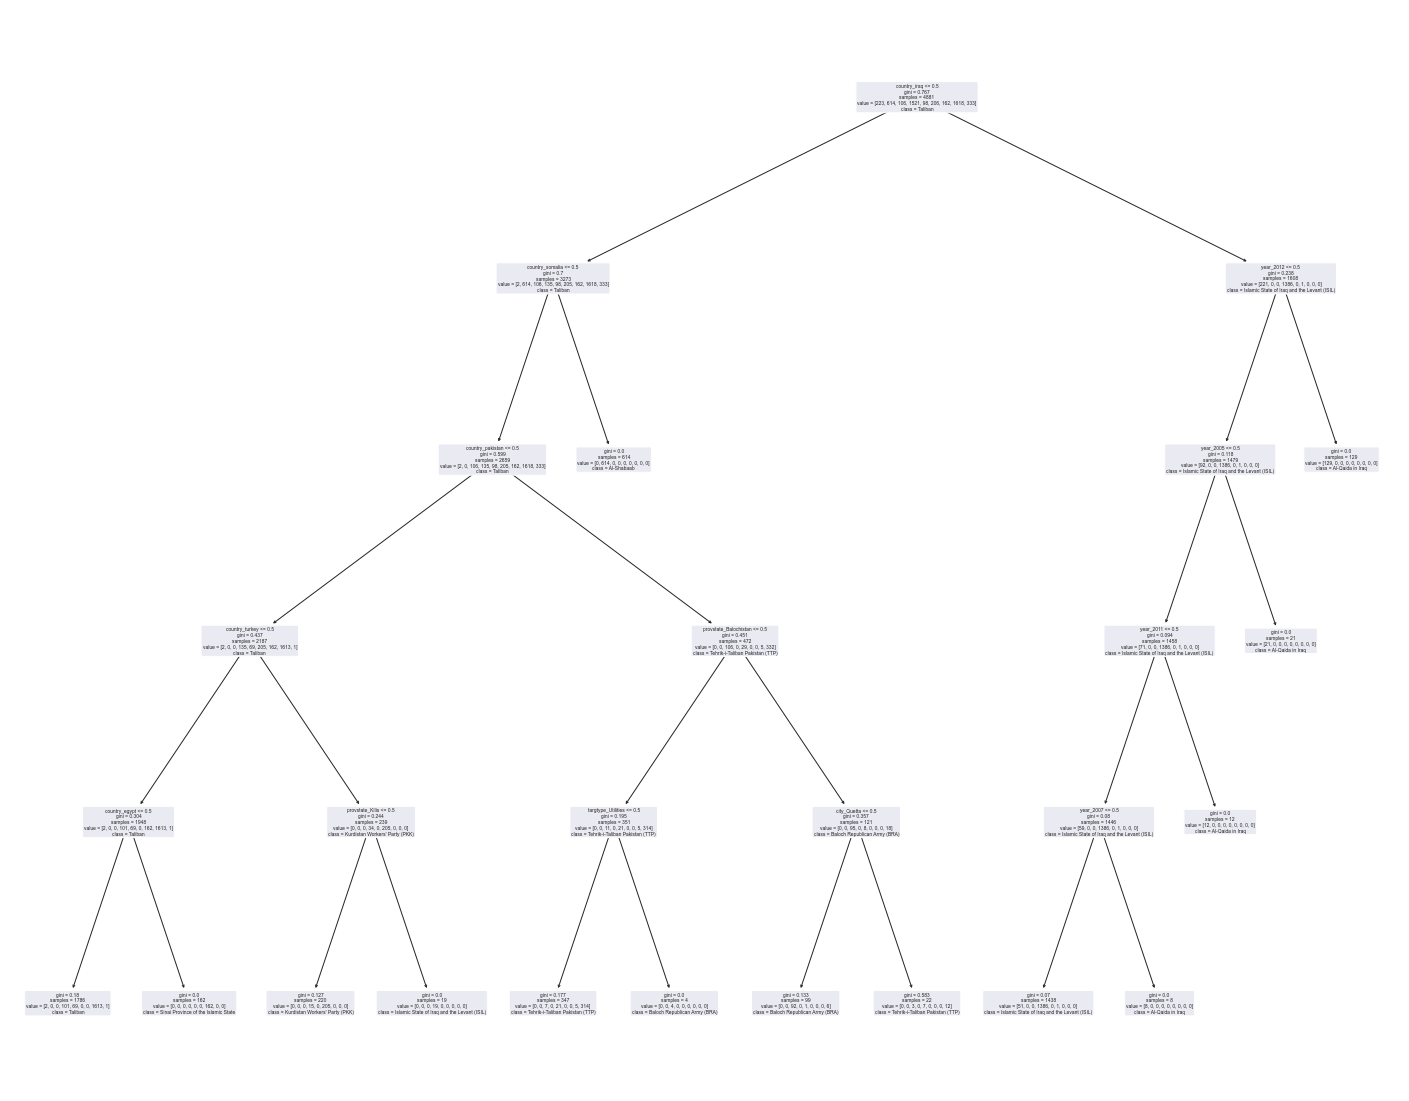

In [48]:
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, rounded=True)
#plt.figure(figsize=(25, 15))
plt.savefig("decision_tree.png")

### Testing on Unk DF

In [49]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=4, random_state=123)

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

# make prediction on train obeservations

y_pred = clf.predict(X_test2)

ValueError: X has 1292 features, but DecisionTreeClassifier is expecting 1282 features as input.

In [ ]:
unk = pd.DataFrame(y_test2)
labels = pd.DataFrame(y_pred)

In [ ]:
production_df2 = production_df2.reset_index()

In [ ]:
production_df2['predictions'] = labels

In [ ]:
production_df2

In [ ]:
production_df2.to_csv('terrorism_predictions.csv')